In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import sklearn
import os
import albumentations as A
from PIL import Image
from torchvision.transforms import Resize
import torch
from sklearn.model_selection import train_test_split
import shutil

In [2]:
paths = [f'TRN_' + str(i).zfill(4) + '.nii.gz' for i in range(1, 918)]
imgs_paths = [os.path.join('images_1', path) for path in paths]
masks_paths = [os.path.join('masks2', path) for path in paths]

## Upload Images

In [3]:
## Start and finish are indexes, therefore they are 0 indexed ##300  voy en 900
start = 0
finish = 1
print('-> Uploading Images')
imgs = [nib.load(imgs_paths[i]) for i in range(start, finish)]
print('-> Images Uploaded \n-> Uploading Masks')
masks = [nib.load(masks_paths[i]) for i in range(start, finish)]
print('-> Masks Uploaded')
print('-> Getting data of Images')
# imgs_data = [img.get_fdata() for img in imgs]
imgs_data = []
for img in imgs:
    try:
        img = img.get_fdata()
        imgs_data.append(img)
    except OSError:
        print(imgs.index(img))

print('-> Images Data Uploaded')
print('-> Getting data of Masks')
masks_data = [mask.get_fdata() for mask in masks]
print('-> Masks Data Uploaded')

-> Uploading Images
-> Images Uploaded 
-> Uploading Masks
-> Masks Uploaded
-> Getting data of Images
-> Images Data Uploaded
-> Getting data of Masks
-> Masks Data Uploaded


In [4]:
def cut_proj(proj):
    xs, ys, zs = np.where(proj!=0)
    cut_img = proj[min(xs) : max(xs) + 1, min(ys) : max(ys) + 1, min(zs) : max(zs) + 1] 
    return cut_img

In [5]:
# projections_3d = list of 3D arrays of the selected parts of the CT Scan
projections_3d = [np.multiply(mask_data, img_data) for mask_data, img_data in zip(masks_data, imgs_data)]

In [6]:
right_lungs = [np.float32(cut_proj(projection[:255,:,:])) for projection in projections_3d] 
left_lungs = [np.float32(cut_proj(projection[255:,:,:])) for projection in projections_3d] 


right_images = [np.average(right_lungs[0], axis = 0), np.average(right_lungs[0], axis = 1), \
          np.average(right_lungs[0], axis = 2)]

left_images = [np.average(left_lungs[0], axis = 0), np.average(left_lungs[0], axis = 1), \
          np.average(left_lungs[0], axis = 2)]


## Save images as np

In [7]:
i = 1 + start
base_path = 'images_np/right_lungs/'
for array in right_lungs:
    np.save(f'{base_path}TRN_' + str(i).zfill(4), array)
    i += 1    

In [8]:
i = 1 + start
base_path = 'images_np/left_lungs/'
for array in left_lungs:
    np.save(f'{base_path}TRN_' + str(i).zfill(4), array)
    i += 1

## Augmentation

In [9]:
transforms = A.Compose([
    A.HorizontalFlip(p= 0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit = 20, p=0.2),
    A.Blur(blur_limit = 6, p=0.15),
    A.GaussNoise(var_limit = 0.003, p=0.3),
    A.OpticalDistortion(p=0.25),
    A.RandomBrightnessContrast(contrast_limit = 0, p=0.3),
])

In [10]:
def aug_fn(image):
    data = {"image":np.float32(image)}
    aug_img0 = transforms(**data)
    aug_img = aug_img0["image"]
    
    return aug_img

In [11]:
def print_imgs(images, title, columns, rows, axis = 'on'):
    fig = plt.figure(figsize=(12, 12))

    plt.title(title)
    for i in range(1, columns*rows + 1):
        img = images[i - 1]
        fig_var = fig.add_subplot(rows, columns, i)
        fig_var.axis('off')
        plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(bottom = 0.27)
    plt.show()

## Preprocessing

In [12]:
def resize_img(img, size):
    resize = Resize(size)
    resized_img = resize(torch.from_numpy(img).T).T
    return resized_img

In [13]:
def average_img(img, axis):
    average = np.average(img, axis = axis) + 1024
    norm_img = (average) / np.amax(average)
    return norm_img

def max_img(img, axis):
    norm_img = (np.amax(img, axis = axis) + 1024) / 1500
    return norm_img

def std_img(img, axis):
    std = (np.std(img, axis = axis) + 1024)
    norm_img = std / np.amax(std)
    return norm_img

In [14]:
def get_2d_proj(images, axis, size = (256, 256)):

    # WITH AUGMENTATION
    # proj_2d = [resize_img(aug_fn(np.dstack(( average_img(img, axis = axis), max_img(img, axis = axis), \
    #                 std_img(img, axis = axis) ))), size) for img in images]
    
    # WITHOUT AUGMENTATION
    proj_2d = [resize_img(np.dstack(( average_img(img, axis = axis), max_img(img, axis = axis), \
                    std_img(img, axis = axis) )), size) for img in images]
    return proj_2d

In [15]:
lungs = []
for lungs_3d in (right_lungs, left_lungs):
    projections_2d_dim_0 = get_2d_proj(lungs_3d, axis = 0, size = (128, 256))

    projections_2d_dim_1 = get_2d_proj(lungs_3d, axis = 1)

    projections_2d_dim_2 = get_2d_proj(lungs_3d, axis = 2)
    
    projections_2d = list(zip(projections_2d_dim_0, projections_2d_dim_1, projections_2d_dim_2))
    # projections_2d is a list of lists [#person1# [2D RGB image axis = 0, 2D RGB image axis = 1, 2D RGB image axis = 2], 
                                     #person2# [2D RGB image axis = 0, 2D RGB image axis = 1, 2D RGB image axis = 2], ...]
    lungs.append(projections_2d)

# lungs = {'right': lungs[0], 'left': lungs[1]}
# OUTPUT: dict with right and left lungs separated in projections_2d format.  

In [16]:
patient = 0
img_ax0 = lungs[0][patient][0]
img_ax1 = lungs[0][patient][1]
img_ax2 = lungs[0][patient][2]
example_right = [img_ax1, img_ax2]

img_ax0 = lungs[1][patient][0]
img_ax1 = lungs[1][patient][1]
img_ax2 = lungs[1][patient][2]
example_left = [img_ax1, img_ax2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


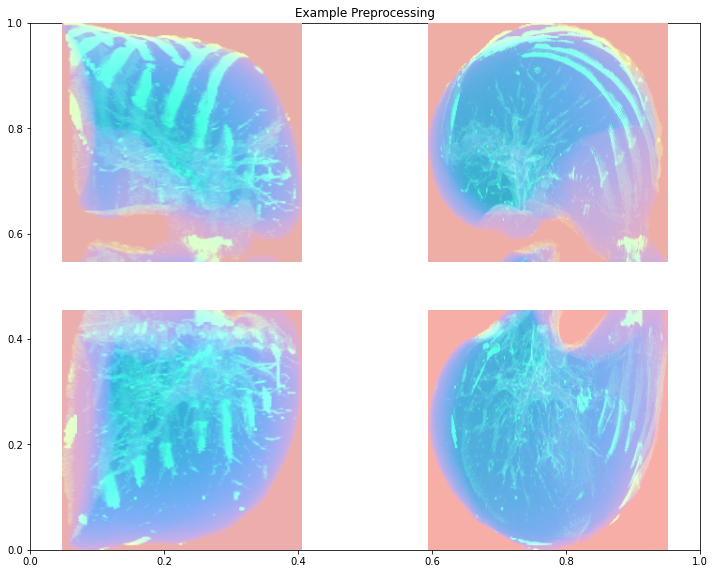

In [17]:
print_imgs(example_right + example_left, 'Example Preprocessing', 2, 2, axis = 'on')

In [18]:
base_path = 'images_jpg_no_aug'
j=-1
for side_lungs in lungs:
    j+=1
    side = 'right' if j == 0 else 'left'
    for i in range(finish - start):
        patient_id = i + start + 1  #starting for 1 the num of patients
        patient = side_lungs[i]
        for axis in range(3):
            img = (np.array(side_lungs[i][axis])*255).astype(np.uint8)
            img = Image.fromarray(img, 'RGB')
            img.save(os.path.join(base_path, f'axis_{axis}/TRN_' + str(patient_id).zfill(4) + f'_{side}.jpg'))
            